In [1]:
import numpy as np

import matplotlib.pyplot as plt
#from scipy.integrate import odeint
#import mpmath as mpmath
#from scipy.optimize import linear_sum_assignment  # Hungarian algorithm 
import scipy

plt.rc('text', usetex=True)

# %matpnlotlib notebook 
%matplotlib inline 

import Husimi   # Quantum routines is used here! Uprop2 routine
#import Harp     # Classical integration routines
import importlib  # for reloading routines if you need to edit them

import pickle  # for storing python classes in binary files 


In [ ]:
importlib.reload(Husimi)  # if you need to reload it!

In [2]:
froot = 'Iter0_'
muprime = r'$\mu$' + '\''
twopi=2*np.pi

In [84]:
# given desired min and max values for the histogram, and a maximum value of a list
# give us a set of bins good for a np histogram
# add the maximum of a list onto the bin array, useful for making histograms without truncation
def mkbinsarr(zmin,zmax,nbins,max_zlist):
    bins_arr = np.linspace(zmin,zmax,nbins)
    #max_zlist = np.max(zlist1)
    max_bin = max(max_zlist,zmax) + 0.01
    bins_arr = np.append(bins_arr,max_bin) 
    return bins_arr

# compute means, standard deviations and standard errors of a list of values 
def perrs(zlist,prefix=''):
    N_z = len(zlist)
    mm_1 = np.mean(zlist); sig_1 = np.std(zlist); std_err_1 = sig_1/np.sqrt(N_z)
    print(prefix,"mean z ={:.3f} += {:.3f}, std z = {:.2f}".format(mm_1, std_err_1, sig_1 ))
    
    z2list = zlist**2  # take the square for computing means k=2
    mm_2 = np.mean(z2list); sig_2 = np.std(z2list); std_err_2 = sig_2/np.sqrt(N_z)
    print(prefix,"mean z2 ={:.3f} += {:.3f}, std z2 = {:.2f}".format(mm_2, std_err_2, sig_2 ))
    
    z3list = zlist**3  # take the cube for computing means k=3
    mm_3 = np.mean(z3list); sig_3 = np.std(z3list); std_err_3 = sig_3/np.sqrt(N_z)
    print(prefix,"mean z3 ={:.3f} += {:.3f}, std z3 = {:.2f}".format(mm_3, std_err_3, sig_3 ))
    mms = np.array([mm_1,mm_2,mm_3])
    sigs = np.array([sig_1,sig_2,sig_3])
    std_errs = np.array([std_err_1,std_err_2,std_err_3])
    return mms,sigs,std_errs
    
def plt1zhist(zlist,xmax):
    #xmax = 10
    bins_arr  = mkbinsarr(0,xmax,100,np.max(zlist))
    fig,ax = plt.subplots(1,1,figsize=(3.2,3.0),dpi=300)
    plt.subplots_adjust(hspace=0,wspace=0,left=0.15,right=0.98,top=0.98,bottom =0.15)
    ax.set_xlim([-0.05,xmax*0.99])
    style4 = {'facecolor': 'cyan',  'edgecolor': 'cyan', 'linewidth': 2.5, 'linestyle':'dotted'}
    ax.hist(zlist   ,bins=bins_arr,density=True,alpha=0.8,cumulative=True,label=r'$$',histtype='step',**style4)
    xarr = np.linspace(0,xmax,100)
    yarr = 1 - np.exp(-xarr)
    ylabel = r'1-$e^{-x}$'
    handles = []
    llw, = ax.plot(xarr,yarr,'k-',lw=0.5,alpha=0.7,label=ylabel)
    handles.append(llw)
    second_legend = ax.legend(handles = handles, borderpad=0.25,handlelength=0.8,handletextpad=0.25,fontsize=15,labelspacing=0.05,\
                         loc = 'upper left')

    plt.show()


  

In [91]:
# class to create pseudorandom floquet systsems
class rec_cls():
    def __init__(self,N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = None):
        self.N = N  # dimension
        self.ntau = N*4  # relevant for Trotterization 
        self.a = a   # baseline values of parameters in hamiltonian 
        self.b = b
        self.eps = eps
        self.mu = mu
        self.mup= mup
        self.taushift = taushift
        self.phishift = phishift

        # ranges if uniform distributions used 
        self.db = db  # the range is [b ,b+db]
        self.deps = deps  # the range is [eps, eps+deps]
        self.dmu = dmu
        self.dmup = dmup
        self.dtau = dtau
        self.dphi = dphi

        self.varlist = varlist   # list of strings to choose type of pseudorandom generator 
        self.nvars = len(varlist)  # numbers of dimensions of choices 

        if (seed != None):
            self.rs = np.random.RandomState(seed)
        else:
            self.rs = None

        # the list of strings varlist 
        # each string in the list has two letters. 
        # the first letter is D or C, 
        #  D for discrete, C for continuous variation distributions 
        # the second letter is 
        #  b for varying b 
        #  t for varying tau
        #  p for varying phi
        #  m for varying mu
        #  r for varying muprime
        #  e for varying epsilon
        # if there are continuous variations then the variables dp,deps, dmu,dmup dtau,dphi give ranges
        # otherwise values 2 pi j/N  all j are used for discrete choices of angles 

    def randj(self,m): # return a randomly selected integer in 0 to and including m-1
        if (self.rs != None):
            j = scipy.stats.randint.rvs(0,m,random_state=self.rs)
        else:
            j = scipy.stats.randint.rvs(0,m)
        return j

    def randuni(self,xmax):  # return a uniform distribution from 0 to xmax 
        if (self.rs != None):
            x = scipy.stats.uniform.rvs(loc=0, scale=xmax, random_state=self.rs)
        else:
            x = scipy.stats.uniform.rvs(loc=0, scale=xmax)
        return x

    # generate a single randomly chosen Floquet propagator 
    def gen1(self):
        b = self.b 
        taushift = self.taushift
        phishift = self.phishift
        mu = self.mu
        mup = self.mup
        eps = self.eps
        for k in range(self.nvars):
            fval = varlist[k][0]  # firstletter 
            sval = varlist[k][1]  # second letter 
            
            if (fval == 'D'):  # discrete varying 
                j = self.randj(self.N)  # choose a random integer
                if (sval == 'b'): # we vary b
                    b+=  twopi*j/self.N
                elif (sval == 't'): # we vary tau0
                    taushift += twopi*j/self.N
                elif (sval == 'p'): # we vary phi0
                    phishift += twopi*j/self.N
            elif (fval == 'C'):  # continous varying 
                if (sval == 'b'): # we vary b
                    b += self.randuni(self.db)
                elif (sval == 'm'): # we vary mu
                    mu += self.randuni(self.dmu)
                elif (sval == 'r'): # we vary mup
                    mup += self.randuni(self.dmup)
                elif (sval == 'p'):  # vary phishift 
                    phishift += self.randuni(self.dphi)
                elif (sval == 't'):  # vary taushift 
                    taushift += self.randuni(self.dtau)
                elif (sval == 'e'):  # vary eps
                    eps += self.randuni(self.deps)
                else:
                    print('varlist err not bmrpte')
            else:
                print('varlist err not D or C')

        # finally make the Floquet propagator
        w,vr,U = Husimi.U_prop2(self.N,self.ntau,self.a,b,eps,mu,mup,taushift,phishift=phishift) 
        return U
            
    # compute a list of |tr UV^dagger|^2 where U,V are generated randomly 
    # Nu is the number of z values to generate 
    def genzlist(self,Nu):
        zlist = np.zeros(Nu)  # storing zs 
        for k in range(Nu):
            U1 = self.gen1()  # randomly choosing a matrix 
            U2 = self.gen1()
            U2_dagger = U2.conjugate().T
            zt = np.trace(np.matmul(U1,U2_dagger))
            z = np.absolute(zt)**2  # |tr UV^dagger}|^2
            #print(zt)
            zlist[k] = z
        mms,sigs,std_errs  = perrs(zlist)  # print out stats 
        self.mms = mms # these are for k=1,2,3 and are numerically measured frame potentials
        self.sigs = sigs
        self.std_errs = std_errs
        return zlist  # return the zlist

#U = fl_a.gen1()

# control class making Haar random stats
class Ha_control():
    def __init__(self,N,seed=None):
        self.N = N
        if (seed != None): 
            self.rs = np.random.RandomState(seed)
        else:
            self.rs = None
            
    def gen1(self):
        if (self.rs != None):
            U_Ha = scipy.stats.unitary_group.rvs(self.N,random_state=self.rs) # single matrix, randomly chosen from Haar
        else:
            U_Ha = scipy.stats.unitary_group.rvs(self.N) # single matrix, randomly chosen from Haar
        return U_Ha
        
    # compute a list of |tr UV^dagger|^2 where U,V are generated randomly 
    # Nu is the number of z values to generate 
    def genzlist(self,Nu):
        zlist = np.zeros(Nu)  # storing zs 
        for k in range(Nu):
            U1 = self.gen1()  # randomly choosing a matrix 
            U2 = self.gen1()
            U2_dagger = U2.conjugate().T
            zt = np.trace(np.matmul(U1,U2_dagger))
            z = np.absolute(zt)**2  # |tr UV^dagger}|^2
            #print(zt)
            zlist[k] = z
        mms,sigs,std_errs  = perrs(zlist)  # print out stats 
        self.mms = mms # these are for k=1,2,3 and are numerically measured frame potentials
        self.sigs = sigs
        self.std_errs = std_errs
        return zlist  # return the zlist

In [231]:
# class for making pseudorandom drifted systems
class drft_cls():
    def __init__(self,N,parms0,d_parms,tau0,phishift,nperiods,Delta_parms0,Delta_d_parms,dtau,dphi,varlist,seed = None):

        self.N = N
        self.parms0 = parms0  # baselines  parms0 = [a,b,eps,mu,mup] 
        self.d_parms = d_parms  # drift parms not per period 
        # end parameters are parms0 + d_parms*twopi*n_periods
        self.tau0 = tau0
        self.phishift = phishift
        self.nperiods = nperiods
        self.ntau = 4*N

        self.Delta_parms0 = Delta_parms0  # range of parms0 if they are varied 
        self.Delta_d_parms = Delta_d_parms  # range of d_parms if they are varied 

        self.endparms = self.parms0 + self.d_parms*twopi*self.nperiods
        self.endparms_max = self.parms0 + self.Delta_parms0 + (self.d_parms + self.Delta_d_parms)*twopi*self.nperiods
        print('endparms', self.endparms)
        print('endparms max', self.endparms_max)

        self.dtau = dtau
        self.dphi = dphi

        self.varlist = varlist   # list of strings to choose type of pseudorandom generator 
        self.nvars = len(varlist)  # numbers of dimensions of choices 

        if (seed != None):
            self.rs = np.random.RandomState(seed)
        else:
            self.rs = None

    def randj(self,m): # return a randomly selected integer in 0 to and including m-1
        if (self.rs != None):
            j = scipy.stats.randint.rvs(0,m,random_state=self.rs)
        else:
            j = scipy.stats.randint.rvs(0,m)
        return j

    def randuni(self,xmax):  # return a uniform distribution from 0 to xmax 
        if (self.rs != None):
            x = scipy.stats.uniform.rvs(loc=0, scale=xmax, random_state=self.rs)
        else:
            x = scipy.stats.uniform.rvs(loc=0, scale=xmax)
        return x
  
    # generate a single pseudorandom unitary 
    def gen1(self):
        parms0 = np.copy(self.parms0)
        d_parms = np.copy(self.d_parms)
        tau0 = self.tau0
        phishift = self.phishift

        for k in range(self.nvars):
            fval = varlist[k][0]  # first letter of string
            if (fval == 'D'):  # discrete varying of phases 
                sval = varlist[k][1]  # second letter 
                j = self.randj(self.N)  # choose a random integer
                if (sval == 'b'): # we vary b
                    parms0[1] +=  twopi*j/self.N
                elif (sval == 't'): # we vary tau0
                    tau0 += twopi*j/self.N
                elif (sval == 'p'): # we vary phi0
                    phishift += twopi*j/self.N
                else:
                    print('varlist err not in D followed by btp')
            elif (fval == 'C'):  # continous varying, uniform distributions done all at once 
                for j in range(5):
                    xmax = self.Delta_parms0[j]    # uniform distn in initial values
                    if (xmax >0):
                        parms0[j] += self.randuni(xmax)
                    ymax = self.Delta_d_parms[j]   # uniform distrn in drift parms
                    if (ymax >0):
                        d_parms[j] += self.randuni(ymax)
                if (self.dtau >0):
                    tau0 += self.randuni(self.dtau)
                if (self.dphi >0):
                    phishift += self.randuni(self.dphi)
            else:
                print('varlist err not D or C')

        # finally make the drifted propagator
        w_var,vr_var,U_var = Husimi.U_prop2_var(self.N,self.ntau,parms0,d_parms,tau0,self.nperiods,phishift=phishift)
        return U_var 

    # compute a list of |tr UV^dagger|^2 where U,V are generated randomly using gen1
    # Nu is the number of z values to generate 
    def genzlist(self,Nu):
        zlist = np.zeros(Nu)  # storing zs 
        for k in range(Nu):
            U1 = self.gen1()  # randomly choosing a matrix 
            U2 = self.gen1()
            U2_dagger = U2.conjugate().T
            zt = np.trace(np.matmul(U1,U2_dagger))
            z = np.absolute(zt)**2  # |tr UV^dagger}|^2
            #print(zt)
            zlist[k] = z
        mms,sigs,std_errs  = perrs(zlist)  # print out stats 
        self.mms = mms  # these are for k=1,2,3 and are numerically measured frame potentials
        self.sigs = sigs
        self.std_errs = std_errs
        return zlist  # return the zlist

#vr_a.gen1()

In [361]:
# Harr random list control 
N=51
control_a = Ha_control(N,seed=5123)
Nu = 4000
zlist_Ha = control_a.genzlist(Nu)
control_a.label = 'Haar'

 mean z =1.003 += 0.016, std z = 0.99
 mean z2 =1.989 += 0.068, std z2 = 4.28
 mean z3 =5.792 += 0.378, std z3 = 23.90


In [ ]:
# Floquet samplers below!

In [360]:
N=51; a = 3; b=0.0; eps = 3.1; mu = 3; mup = 3.1;taushift=0.0;phishift=0.0;
db = twopi; deps = 0.0; dmu= 0.0; dmup= 0.0; dphi=twopi; dtau = twopi; 
varlist = ['Db','Dp'] # discrete variations in b and phi
fl_a2 = rec_cls(N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = 200)  # still big!
Nu = 4000
zlist_a2 = fl_a2.genzlist(Nu) 
fl_a2.label =  r'D$b\phi$'

 mean z =3.333 += 1.129, std z = 71.42
 mean z2 =5112.482 += 2928.356, std z2 = 185205.48
 mean z3 =13203873.585 += 7616556.145, std z3 = 481713306.92


In [359]:
# floquet 
N=51; a = 3; b=0.0; eps = 3.1; mu = 3; mup = 3.1;taushift=0.0;phishift=0.0;
db = twopi; deps = 0.0; dmu= 0.0; dmup= 0.0; dphi=twopi; dtau = twopi;  # random variations 
varlist = ['Db','Dt'] # discrete variations in b and tau
fl_a = rec_cls(N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = 1)
Nu = 4000
zlist_a = fl_a.genzlist(Nu) # 
fl_a.label = r'D$b\tau$' 

 mean z =1.439 += 0.071, std z = 4.50
 mean z2 =22.308 += 10.255, std z2 = 648.61
 mean z3 =2661.555 += 1725.791, std z3 = 109148.59


In [358]:
N=51; a = 3; b=0.0; eps = 3.1; mu = 3; mup = 3.1;taushift=0.0;phishift=0.0;
db = twopi; deps = 0.0; dmu= 0.0; dmup= 0.0; dphi=twopi; dtau = twopi; 
varlist = ['Cb','Cp']  # continous variations in b, phi
Nu = 4000
fl_c = rec_cls(N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = 14)
zlist_c = fl_c.genzlist(Nu) # 
fl_c.label =r'C$b\phi$'


 mean z =1.345 += 0.028, std z = 1.75
 mean z2 =4.880 += 0.552, std z2 = 34.90
 mean z3 =53.127 += 17.819, std z3 = 1126.99


In [356]:
N=51; a = 3; b=0.0; eps = 3.1; mu = 3; mup = 3.1;taushift=0.0;phishift=0.0;
db = twopi; deps = 0.0; dmu= 0.0; dmup= 0.0; dphi=twopi; dtau = twopi; 
varlist = ['Cb','Ct'] # continous variations in b, tau
Nu = 4000
fl_b = rec_cls(N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = 7)  # was 6 at 2000
zlist_b = fl_b.genzlist(Nu) # 
fl_b.label = r'C$b\tau$'


 mean z =1.323 += 0.063, std z = 3.99
 mean z2 =17.705 += 11.850, std z2 = 749.48
 mean z3 =2703.464 += 2554.951, std z3 = 161589.31


In [353]:
N=51; a = 3; b=0.0; eps = 3.1; mu = 3; mup = 3.1;taushift=0.0;phishift=0.0;
db = twopi; deps = 0.0; dmu= 3.0; dmup= 0.0; dphi=twopi; dtau = twopi; 
varlist = ['Ct','Cm'] # continous variations in tau and mu
Nu = 4000
fl_c2 = rec_cls(N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = 1255)
zlist_c2 = fl_c2.genzlist(Nu)  #
fl_c2.label = r'C$\tau\mu$'


 mean z =1.172 += 0.032, std z = 2.05
 mean z2 =5.584 += 1.345, std z2 = 85.06
 mean z3 =145.428 += 81.926, std z3 = 5181.49


In [350]:
N=51; a = 3; b=0.0; eps = 3.1; mu = 3; mup = 3.1;taushift=0.0;phishift=0.0;
db = twopi; deps = 0.0; dmu= 3.0; dmup= 0.0; dphi=twopi; dtau = twopi; 
varlist = ['Cb','Cp','Cm'] # continous variations in b, phi and mu
Nu = 4000
fl_e = rec_cls(N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = 115)
zlist_e = fl_e.genzlist(Nu) # 
fl_e.label = r'C$b\phi\mu$'


 mean z =1.017 += 0.016, std z = 1.02
 mean z2 =2.071 += 0.070, std z2 = 4.41
 mean z3 =6.200 += 0.357, std z3 = 22.57


In [351]:
N=51; a = 3; b=0.0; eps = 3.1; mu = 3; mup = 3.1;taushift=0.0;phishift=0.0;
db = twopi; deps = 0.0; dmu= 3.0; dmup= 0.0; dphi=twopi; dtau = twopi; 
varlist = ['Cb','Ct','Cm'] # continous variations in b, tau and mu
Nu = 4000
fl_d = rec_cls(N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = 15)
zlist_d = fl_d.genzlist(Nu) #
fl_d.label = r'C$b\tau\mu$'


 mean z =1.038 += 0.017, std z = 1.09
 mean z2 =2.271 += 0.124, std z2 = 7.86
 mean z3 =8.782 += 2.026, std z3 = 128.15


In [352]:
N=51; a = 3; b=0.0; eps = 3.1; mu = 3; mup = 3.1;taushift=0.0;phishift=0.0;
db = twopi; deps = 0.0; dmu= 3.0; dmup= 2.0; dphi=twopi; dtau = twopi; 
varlist = ['Cb','Ct','Cm','Cr']  # continuous variations in b, tau, mu and muprime
Nu = 4000
fl_f = rec_cls(N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = 1233)
zlist_f = fl_f.genzlist(Nu) # 
fl_f.label = r'C$_1b\tau\mu$' + muprime 


 mean z =1.021 += 0.016, std z = 1.00
 mean z2 =2.034 += 0.065, std z2 = 4.09
 mean z3 =5.810 += 0.302, std z3 = 19.10


In [363]:
# check lower N, even 
N=30; a = 3; b=0.0; eps = 3.1; mu = 3; mup = 3.1;taushift=0.0;phishift=0.0;
db = twopi; deps = 0.0; dmu= 3.0; dmup= 2.0; dphi=twopi; dtau = twopi; 
varlist = ['Cb','Ct','Cm','Cr']  # continuous variations in b, tau, mu and muprime
Nu = 4000
fl_h = rec_cls(N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = 1033)
zlist_h = fl_h.genzlist(Nu) # 
fl_h.label = r'C$_2b\tau\mu$' + muprime 


 mean z =0.998 += 0.017, std z = 1.06
 mean z2 =2.120 += 0.092, std z2 = 5.79
 mean z3 =7.356 += 0.780, std z3 = 49.36


In [378]:
# check lower N, odd 
N=31; a = 3; b=0.0; eps = 3.1; mu = 3; mup = 3.1;taushift=0.0;phishift=0.0;
db = twopi; deps = 0.0; dmu= 3.0; dmup= 2.0; dphi=twopi; dtau = twopi; 
varlist = ['Cb','Ct','Cm','Cr']  # continuous variations in b, tau, mu and muprime
Nu = 4000
fl_h2 = rec_cls(N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = 1033)
zlist_h2 = fl_h2.genzlist(Nu) # 
fl_h2.label = r'C$_2b\tau\mu$' + muprime  # no difference so not needed!

 mean z =1.042 += 0.017, std z = 1.06
 mean z2 =2.218 += 0.087, std z2 = 5.52
 mean z3 =7.419 += 0.646, std z3 = 40.87


In [362]:
# check higher N, even 
N=70; a = 3; b=0.0; eps = 3.1; mu = 3; mup = 3.1;taushift=0.0;phishift=0.0;
db = twopi; deps = 0.0; dmu= 3.0; dmup= 2.0; dphi=twopi; dtau = twopi; 
varlist = ['Cb','Ct','Cm','Cr']  # continuous variations in b, tau, mu and muprime
Nu = 4000
fl_i = rec_cls(N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = 19033)
zlist_i = fl_i.genzlist(Nu) # 
fl_i.label = r'C$_3b\tau\mu$' + muprime 


 mean z =1.007 += 0.017, std z = 1.06
 mean z2 =2.141 += 0.106, std z2 = 6.69
 mean z3 =7.723 += 1.389, std z3 = 87.85


In [397]:
# check like Tb
N=51; a = 3; b=0.0; eps = 3.1; mu = 1; mup = 0.0;taushift=0.0;phishift=0.0;
db = twopi; deps = 0.0; dmu= 3.0; dmup= 2.0; dphi=twopi; dtau = twopi; 
varlist = ['Cb','Ct','Cm','Cr']  # continuous variations in b, tau, mu and muprime
Nu = 4000
fl_g = rec_cls(N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = 5233)
zlist_g = fl_g.genzlist(Nu) # 
fl_g.label = r'C$_4b\tau\mu$' + muprime 

 mean z =1.186 += 0.022, std z = 1.38
 mean z2 =3.304 += 0.258, std z2 = 16.29
 mean z3 =20.630 += 5.611, std z3 = 354.88


In [394]:
# check higher N, odd
N=71; a = 3; b=0.0; eps = 3.1; mu = 3; mup = 3.1;taushift=0.0;phishift=0.0;
db = twopi; deps = 0.0; dmu= 3.0; dmup= 2.0; dphi=twopi; dtau = twopi; 
varlist = ['Cb','Ct','Cm','Cr']  # continuous variations in b, tau, mu and muprime
Nu = 4000
fl_i2 = rec_cls(N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = 192033)
zlist_i2 = fl_i2.genzlist(Nu)  # 
fl_i2.label =  'not used'
# seems like odd dimensions are systematically lower? I am not sure why!

 mean z =1.016 += 0.016, std z = 0.99
 mean z2 =2.019 += 0.070, std z2 = 4.40
 mean z3 =5.934 += 0.423, std z3 = 26.73


NameError: name 'fl_i1' is not defined

In [395]:
fl_i2.label =  'not used'

In [406]:
# check mu mu' without angles 
N=51; a = 3; b=0.0; eps = 3.1; mu = 3; mup = 3.1;taushift=0.0;phishift=0.0;
db = twopi; deps = 0.0; dmu= 4.0; dmup= 4.0; dphi=twopi; dtau = twopi; 
varlist = ['Cm','Cr']  # continuous variations in mu and muprime
Nu = 4000
fl_j = rec_cls(N,a,b,eps,mu,mup,taushift,phishift,db,deps,dmu,dmup,dphi,dtau,varlist,seed = 7333)
zlist_j = fl_j.genzlist(Nu) # 
fl_j.label = r'C$\mu$' + muprime   

 mean z =4.218 += 0.725, std z = 45.83
 mean z2 =2118.496 += 1314.057, std z2 = 83108.26
 mean z3 =3662473.757 += 2607049.987, std z3 = 164884318.68


In [407]:
nruns = 12
mm_large = np.zeros((nruns,3))
stde_large = np.zeros((nruns,3))
i=0
mm_large[i,:] = fl_j.mms; stde_large[i,:] =  fl_j.std_errs; i+=1
mm_large[i,:] =fl_a2.mms; stde_large[i,:] = fl_a2.std_errs; i+=1
mm_large[i,:] = fl_a.mms; stde_large[i,:] =  fl_a.std_errs; i+=1
mm_large[i,:] = fl_c.mms; stde_large[i,:] =  fl_c.std_errs; i+=1
mm_large[i,:] = fl_b.mms; stde_large[i,:] =  fl_b.std_errs; i+=1
mm_large[i,:] = fl_c2.mms; stde_large[i,:] =  fl_c2.std_errs; i+=1
mm_large[i,:] = fl_e.mms; stde_large[i,:] =  fl_e.std_errs; i+=1
mm_large[i,:] = fl_d.mms; stde_large[i,:] =  fl_d.std_errs; i+=1
mm_large[i,:] = fl_f.mms; stde_large[i,:] =  fl_f.std_errs; i+=1
mm_large[i,:] = fl_h.mms; stde_large[i,:] =  fl_h.std_errs; i+=1
mm_large[i,:] = fl_i.mms; stde_large[i,:] =  fl_i.std_errs; i+=1
mm_large[i,:] = fl_g.mms; stde_large[i,:] =  fl_g.std_errs; i+=1
labels = [\
          fl_j.label,\
          fl_a2.label,\
          fl_a.label,\
          fl_c.label,\
          fl_b.label,\
          fl_c2.label,\
          fl_e.label,\
          fl_d.label,\
          fl_f.label,\
          fl_h.label,\
          fl_i.label,\
          fl_g.label ]

          
#labels = [
#         r'C$b\mu$' + muprime,\  7  j
#         r'D$b\phi$',\ 0  a2 
#         r'D$b\tau$',\  1   a
#         r'C$b\phi$',\  2   c
#         r'C$b\tau$',\  3   b
#         r'C$\tau\mu$',\  4   c2
#         r'C$b\phi\mu$',\  5  e
#         r'C$b\tau\mu$',\  6  d
#         r'C$_1b\tau\mu$' + muprime,\  8  f 
#         r'C$_2b\tau\mu$' + muprime,\  9 h 
#         r'C$_3b\tau\mu$' + muprime,\  10 i
#         r'C$_4b\tau\mu$' + muprime ] 11  g

print('frame potentials')
for i in range(nruns):
    print(labels[i], ' & {:.2f} $\\pm$ {:.2f} &  {:.2f} $\\pm$ {:.2f} &  {:.2f} $\\pm$ {:.2f} \\\\ '.format(\
        mm_large[i,0],stde_large[i,0], \
        mm_large[i,1],stde_large[i,1],\
        mm_large[i,2],stde_large[i,2]))

print('')

print('Haar-control & {:.2f} $\\pm$ {:.2f} &  {:.2f} $\\pm$ {:.2f} &  {:.2f} $\\pm$ {:.2f} \\\\ '.format(\
        control_a.mms[0],control_a.std_errs[0], \
        control_a.mms[1],control_a.std_errs[1], \
        control_a.mms[2],control_a.std_errs[2] ))
       
print('varepsilon estimate')
# varepilon estimates 
i=7  #c1btaumumu'
print(labels[i],'& {:.2f} & {:.2f} & {:.2f}'.format( \
    np.sqrt(stde_large[i,0]),np.sqrt(stde_large[i,1]), np.sqrt(stde_large[i,2])))

frame potentials
C$\mu$$\mu$'  & 4.22 $\pm$ 0.72 &  2118.50 $\pm$ 1314.06 &  3662473.76 $\pm$ 2607049.99 \\ 
D$b\phi$  & 3.33 $\pm$ 1.13 &  5112.48 $\pm$ 2928.36 &  13203873.59 $\pm$ 7616556.15 \\ 
D$b\tau$  & 1.44 $\pm$ 0.07 &  22.31 $\pm$ 10.26 &  2661.56 $\pm$ 1725.79 \\ 
C$b\phi$  & 1.35 $\pm$ 0.03 &  4.88 $\pm$ 0.55 &  53.13 $\pm$ 17.82 \\ 
C$b\tau$  & 1.32 $\pm$ 0.06 &  17.71 $\pm$ 11.85 &  2703.46 $\pm$ 2554.95 \\ 
C$\tau\mu$  & 1.17 $\pm$ 0.03 &  5.58 $\pm$ 1.34 &  145.43 $\pm$ 81.93 \\ 
C$b\phi\mu$  & 1.02 $\pm$ 0.02 &  2.07 $\pm$ 0.07 &  6.20 $\pm$ 0.36 \\ 
C$b\tau\mu$  & 1.04 $\pm$ 0.02 &  2.27 $\pm$ 0.12 &  8.78 $\pm$ 2.03 \\ 
C$_1b\tau\mu$$\mu$'  & 1.02 $\pm$ 0.02 &  2.03 $\pm$ 0.06 &  5.81 $\pm$ 0.30 \\ 
C$_2b\tau\mu$$\mu$'  & 1.00 $\pm$ 0.02 &  2.12 $\pm$ 0.09 &  7.36 $\pm$ 0.78 \\ 
C$_3b\tau\mu$$\mu$'  & 1.01 $\pm$ 0.02 &  2.14 $\pm$ 0.11 &  7.72 $\pm$ 1.39 \\ 
C$_4b\tau\mu$$\mu$'  & 1.19 $\pm$ 0.02 &  3.30 $\pm$ 0.26 &  20.63 $\pm$ 5.61 \\ 

Haar-control & 1.00 $\pm$ 0

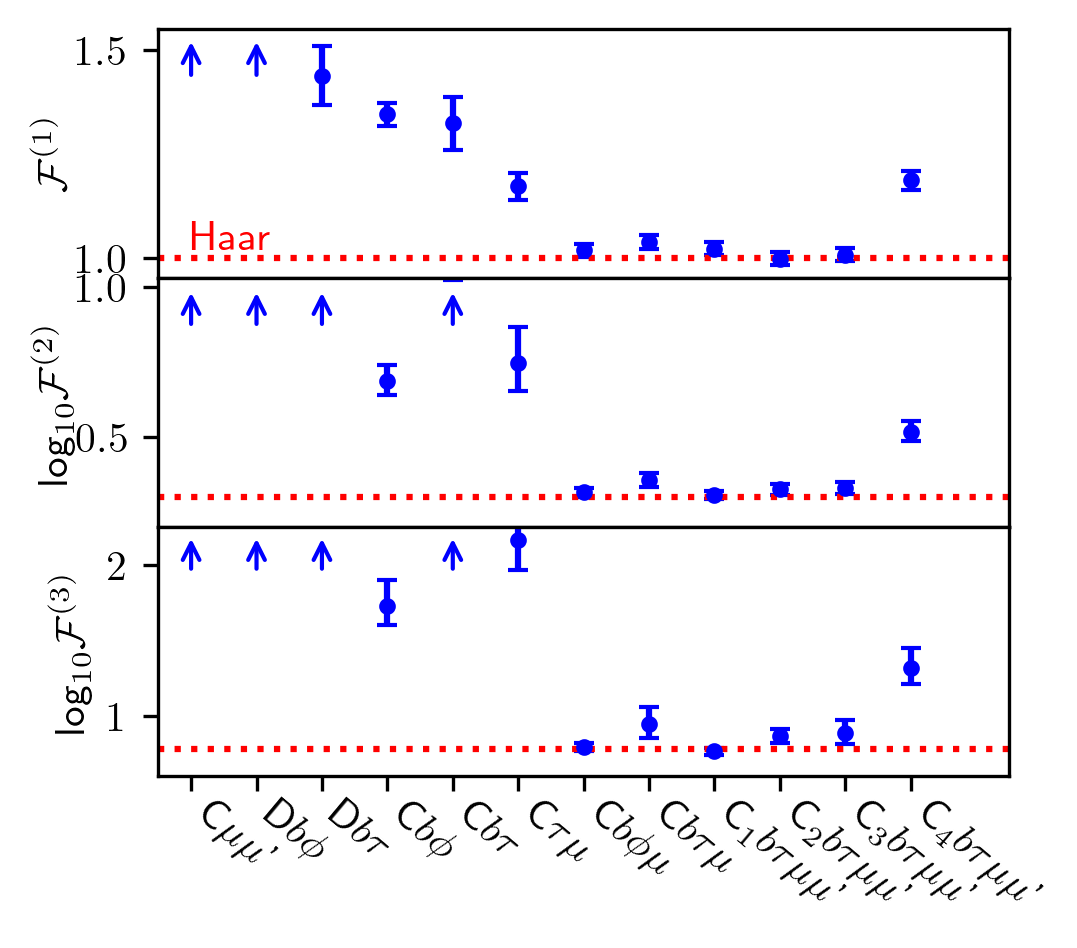

In [411]:
fig,axarr = plt.subplots(3,1,sharex=True,figsize=(3.5,3),dpi=300)
plt.subplots_adjust(wspace=0,hspace=0,bottom=0.15,top=0.98,left=0.16,right=0.97)
karr = np.arange(nruns)
j=0 
yvals = np.squeeze( mm_large[:,j])
yerrs = np.squeeze( stde_large[:,j])
axarr[j].errorbar(karr,yvals,yerr = yerrs,capsize=2.3,fmt='o',ms=3,color='blue')
for j in range(1,3):
    yvals = np.squeeze( mm_large[:,j])
    ylvals = np.log10(yvals)
    yerrs = np.squeeze( stde_large[:,j])
    yuvals = yvals + yerrs
    ybvals = yvals - yerrs
    ylu = np.log10(yuvals)
    ylb = np.log10(ybvals)
    yerr_up = ylu - ylvals 
    yerr_down = ylvals - ylb
    axarr[j].errorbar(karr,ylvals,yerr = [yerr_up,yerr_down],capsize=2.3,fmt='o',ms=3,color='blue')

axarr[0].set_xlim([-0.5,max(karr)+1.5])
axarr[0].set_ylim([0.95,1.55])
axarr[1].set_ylim([0.2,1.03])
axarr[2].set_ylim([0.6,2.25])
#
axarr[0].annotate("", xytext=(0, 1.42), xy=(0, 1.54), arrowprops=dict(arrowstyle="->",ec='blue'))
axarr[0].annotate("", xytext=(1, 1.42), xy=(1, 1.54), arrowprops=dict(arrowstyle="->",ec='blue'))
#
axarr[1].annotate("", xytext=(0, 0.85), xy=(0, 1.01), arrowprops=dict(arrowstyle="->",ec='blue'))
axarr[1].annotate("", xytext=(1, 0.85), xy=(1, 1.01), arrowprops=dict(arrowstyle="->",ec='blue'))
axarr[1].annotate("", xytext=(2, 0.85), xy=(2, 1.01), arrowprops=dict(arrowstyle="->",ec='blue'))
axarr[1].annotate("", xytext=(4, 0.85), xy=(4, 1.01), arrowprops=dict(arrowstyle="->",ec='blue'))
#
axarr[2].annotate("", xytext=(0, 1.92), xy=(0, 2.23), arrowprops=dict(arrowstyle="->",ec='blue'))
axarr[2].annotate("", xytext=(1, 1.92), xy=(1, 2.23), arrowprops=dict(arrowstyle="->",ec='blue'))
axarr[2].annotate("", xytext=(2, 1.92), xy=(2, 2.23), arrowprops=dict(arrowstyle="->",ec='blue'))
axarr[2].annotate("", xytext=(4, 1.92), xy=(4, 2.23), arrowprops=dict(arrowstyle="->",ec='blue'))
xmin,xmax = axarr[0].get_xlim()
axarr[0].plot([xmin,xmax],[1,1],'r:')
axarr[1].plot([xmin,xmax],[np.log10(2.),np.log10(2.)],'r:')
axarr[2].plot([xmin,xmax],[np.log10(6.),np.log10(6.)],'r:')
axarr[2].tick_params(axis='x', which='major', pad=1)
axarr[2].set_xticks(karr,labels,rotation=-40,ha='left')   
axarr[0].set_ylabel(r'${\mathcal F}^{(1)}$',labelpad=0.1)
axarr[1].set_ylabel(r'log$_{10}{\mathcal F}^{(2)}$',labelpad=0.3)
axarr[2].set_ylabel(r'log$_{10}{\mathcal F}^{(3)}$')
axarr[0].annotate('Haar',xytext=(0,1.02),xy=(0,1),color='red',fontsize=10)
plt.savefig(froot+'fp_fl2.png')
plt.show()

In [ ]:
### Drifting variants! # don't really care about discrete b values 

In [319]:
N=51; a0 = 3; b0=0.0; eps0 = 3.01; mu0 = 1.0; mup0 = 0.5;tau0=0.0;phishift=0.0;
db = 0.0
dmu = 0.1
dmup = 0.15
nperiods =3
parms0 = np.array([a0,b0,eps0,mu0,mup0])
d_parms = np.array([0.0,db,0.0,dmu,dmup])
Delta_parms0 = np.array([0.0,0.0,0.0,0.0,0.0])
Delta_d_parms = np.array([0.0,0.1,0.0,0.5,0.0])  # varying drift rate in mu,b
dtau = 0.0; dphi=0.0
varlist = ['C']
vr_b = drft_cls(N,parms0,d_parms,tau0,phishift,nperiods,Delta_parms0,Delta_d_parms,dtau,dphi,varlist,seed = 1366)
Nu = 2000
zlist_vb = vr_b.genzlist(Nu) 
vr_b.label = r'Dr$_1$'+r'$\dot b\dot\mu$' 

endparms [3.         0.         3.01       2.88495559 3.32743339]
endparms max [ 3.          1.88495559  3.01       12.30973355  3.32743339]
 mean z =1.260 += 0.085, std z = 3.79
 mean z2 =15.946 += 10.440, std z2 = 466.88
 mean z3 =1613.180 += 1482.502, std z3 = 66299.50


In [320]:
# drifting variants
N=51; a0 = 3; b0=0.0; eps0 = 3.01; mu0 = 1.0; mup0 = 0.5;tau0=0.0;phishift=0.0;
db = 0.0
dmu = 0.1
dmup = 0.15
nperiods =3
parms0 = np.array([a0,b0,eps0,mu0,mup0])
d_parms = np.array([0.0,db,0.0,dmu,dmup])
Delta_parms0 = np.array([0.0,twopi,0.0,0.0,0.0])  # varying b0
Delta_d_parms = np.array([0.0,0.0,0.0,0.5,0.0])  # varying drift rate in mu
dtau = 0.0; dphi=0.0
varlist = ['C']
vr_a = drft_cls(N,parms0,d_parms,tau0,phishift,nperiods,Delta_parms0,Delta_d_parms,dtau,dphi,varlist,seed = 4)
Nu = 2000
zlist_va = vr_a.genzlist(Nu) # 
vr_a.label = r'Dr$_2$'+r'$b\dot\mu$' 

endparms [3.         0.         3.01       2.88495559 3.32743339]
endparms max [ 3.          6.28318531  3.01       12.30973355  3.32743339]
 mean z =1.023 += 0.023, std z = 1.01
 mean z2 =2.074 += 0.096, std z2 = 4.28
 mean z3 =6.104 += 0.459, std z3 = 20.55


In [315]:
N=51; a0 = 3; b0=0.0; eps0 = 3.01; mu0 = 1.0; mup0 = 0.5;tau0=0.0;phishift=0.0;
db = 0.0
dmu = 0.1
dmup = 0.15
nperiods =3
parms0 = np.array([a0,b0,eps0,mu0,mup0])
d_parms = np.array([0.0,db,0.0,dmu,dmup])
Delta_parms0 = np.array([0.0,0.0,0.0,0.0,0.0])
Delta_d_parms = np.array([0.0,0.0,0.0,0.5,0.0])  # varying drift rate in mu
dtau = twopi; dphi=0.0                          # varying in tau
varlist = ['C']
vr_c2 = drft_cls(N,parms0,d_parms,tau0,phishift,nperiods,Delta_parms0,Delta_d_parms,dtau,dphi,varlist,seed = 30)
Nu = 2000
zlist_vc2 = vr_c2.genzlist(Nu) # 
vr_c2.label = r'Dr$_3$'+r'$\tau\dot\mu$' 

endparms [3.         0.         3.01       2.88495559 3.32743339]
endparms max [ 3.          0.          3.01       12.30973355  3.32743339]
 mean z =0.997 += 0.023, std z = 1.01
 mean z2 =2.023 += 0.113, std z2 = 5.07
 mean z3 =6.530 += 0.764, std z3 = 34.18


In [314]:
N=51; a0 = 3; b0=0.0; eps0 = 3.01; mu0 = 1.0; mup0 = 0.5;tau0=0.0;phishift=0.0;
db = 0.1                                        # also drifting in b!
dmu = 0.1
dmup = 0.15
nperiods =3
parms0 = np.array([a0,b0,eps0,mu0,mup0])
d_parms = np.array([0.0,db,0.0,dmu,dmup])
Delta_parms0 = np.array([0.0,0.0,0.0,0.0,0.0])
Delta_d_parms = np.array([0.0,0.0,0.0,0.5,0.0])  # varying drift rate in mu
dtau = twopi; dphi=0.0                          # varying in tau
varlist = ['C']
vr_c = drft_cls(N,parms0,d_parms,tau0,phishift,nperiods,Delta_parms0,Delta_d_parms,dtau,dphi,varlist,seed = 51)
Nu = 2000
zlist_vc = vr_c.genzlist(Nu)  # 
vr_c.label = r'Dr$_4$'+r'$\tau\dot\mu$' 

endparms [3.         1.88495559 3.01       2.88495559 3.32743339]
endparms max [ 3.          1.88495559  3.01       12.30973355  3.32743339]
 mean z =1.028 += 0.025, std z = 1.10
 mean z2 =2.259 += 0.165, std z2 = 7.37
 mean z3 =8.860 += 1.844, std z3 = 82.48


In [313]:
N=51; a0 = 3; b0=0.0; eps0 = 3.01; mu0 = 1.0; mup0 = 0.5;tau0=0.0;phishift=0.0;
db = 0.0
dmu = 0.1
dmup = 0.15
nperiods =3
parms0  = np.array([a0 ,b0,eps0,mu0,mup0])
d_parms = np.array([0.0,db,0.0,dmu,dmup])
Delta_parms0 = np.array([0.0,0.0,0.0,0.0,0.0])
Delta_d_parms= np.array([0.0,0.0,0.0,0.5,0.5])  # varying drift rate in mu, mup
dtau = twopi; dphi=0.0                           # and varying in tau
varlist = ['C']
vr_d = drft_cls(N,parms0,d_parms,tau0,phishift,nperiods,Delta_parms0,Delta_d_parms,dtau,dphi,varlist,seed = 303)
Nu = 2000
zlist_vd = vr_d.genzlist(Nu) # 
vr_d.label = r'Dr$_5$'+r'$\tau\dot\mu\dot\mu$' + '\''

endparms [3.         0.         3.01       2.88495559 3.32743339]
endparms max [ 3.          0.          3.01       12.30973355 12.75221135]
 mean z =0.995 += 0.022, std z = 0.99
 mean z2 =1.961 += 0.094, std z2 = 4.22
 mean z3 =5.709 += 0.488, std z3 = 21.82


In [312]:
N=51; a0 = 3; b0=0.0; eps0 = 3.01; mu0 = 1.0; mup0 = 0.5;tau0=0.0;phishift=0.0;
db = 0.0
dmu = 0.1
dmup = 0.15
nperiods =3
parms0 = np.array([a0,b0,eps0,mu0,mup0])
d_parms = np.array([0.0,db,0.0,dmu,dmup])
Delta_parms0 = np.array([0.0,0.0,0.5,0.0,0.0])  # random selection of eps
Delta_d_parms = np.array([0.0,0.0,0.0,0.5,0.0])  # varying drift rate in mu
dtau = 0.0; dphi=0.0  # 
varlist = ['C']
vr_e = drft_cls(N,parms0,d_parms,tau0,phishift,nperiods,Delta_parms0,Delta_d_parms,dtau,dphi,varlist,seed = 301)
Nu = 2000
zlist_ve = vr_e.genzlist(Nu)   # vr_e.label = 'Dr' not used!

endparms [3.         0.         3.01       2.88495559 3.32743339]
endparms max [ 3.          0.          3.51       12.30973355  3.32743339]
 mean z =6.182 += 1.969, std z = 88.04
 mean z2 =7789.799 += 4157.905, std z2 = 185947.17
 mean z3 =15719977.630 += 9729715.926, std z3 = 435126124.23


In [270]:
N=51; a0 = 3; b0=0.0; eps0 = 2.01; mu0 = 1.0; mup0 = 0.5;tau0=0.0;phishift=0.0;  # notice lower eps0
db = 0.0
dmu = 0.1
dmup = 0.15
nperiods =3
parms0 = np.array([a0,b0,eps0,mu0,mup0])
d_parms = np.array([0.0,db,0.0,dmu,dmup])
Delta_parms0 = np.array([0.0,0.0,0.0,0.0,0.0])  
Delta_d_parms = np.array([0.0,0.0,0.1,0.5,0.0])  # varying drift rate in mu,eps0
dtau = 0.0; dphi=0.0  # 
varlist = ['C']
vr_f = drft_cls(N,parms0,d_parms,tau0,phishift,nperiods,Delta_parms0,Delta_d_parms,dtau,dphi,varlist,seed = 9901)
Nu = 1000
zlist_vf = vr_f.genzlist(Nu)    # vr_f.label = 'Dr' not used!

endparms [3.         0.         2.01       2.88495559 3.32743339]
endparms max [ 3.          0.          3.89495559 12.30973355  3.32743339]
 mean z =2.333 += 0.833, std z = 26.36
 mean z2 =700.045 += 678.427, std z2 = 21453.76
 mean z3 =560378.347 += 558885.099, std z3 = 17673498.63


In [373]:
if (1==2):
    vr_b.label = r'Dr$_1$'+r'$\dot b\dot\mu$' 
    vr_a.label = r'Dr$_2$'+r'$b\dot\mu$' 
    vr_c2.label = r'Dr$_3$'+r'$\tau\dot\mu$' 
    vr_c.label = r'Dr$_4$'+r'$\tau\dot\mu$' 
    vr_d.label = r'Dr$_5$'+r'$\tau\dot\mu\dot\mu$' + '\''

In [377]:
nruns_vr = 5
mm_large_vr = np.zeros((nruns_vr,3))
stde_large_vr = np.zeros((nruns_vr,3))
i=0
mm_large_vr[i,:] =vr_b.mms; stde_large_vr[i,:] = vr_b.std_errs; i+=1
mm_large_vr[i,:] =vr_a.mms; stde_large_vr[i,:] = vr_a.std_errs; i+=1
mm_large_vr[i,:] =vr_c2.mms; stde_large_vr[i,:] = vr_c2.std_errs; i+=1
mm_large_vr[i,:] =vr_c.mms; stde_large_vr[i,:] = vr_c.std_errs; i+=1
mm_large_vr[i,:] =vr_d.mms; stde_large_vr[i,:] = vr_d.std_errs; i+=1
dotb = r'$\dot b$'
dotmu = r'$\dot \mu$'
dotmup = r'$\dot \mu$' + '\''
labels_vr = [ vr_b.label, vr_a.label, vr_c2.label, vr_c.label, vr_d.label]
#labels_vr = [r'Dr$_1$'+dotb+dotmu, \
#             r'Dr$_2$'+'$b$'+ dotmu,\
#             r'Dr$_3$' + r'$\tau$'+dotmu, \
#             r'Dr$_4$' + r'$\tau$'+dotmu,\
#             r'Dr$_5$' + r'$\tau$'+dotmu + dotmup, \
#             r'Dr$_6$'        ]

print('frame potentials Dr set')
for i in range(nruns_vr):
    print(labels_vr[i], ' & {:.2f} $\\pm$ {:.2f} &  {:.2f} $\\pm$ {:.2f} &  {:.2f} $\\pm$ {:.2f} \\\\ '.format(\
        mm_large_vr[i,0],stde_large_vr[i,0], \
        mm_large_vr[i,1],stde_large_vr[i,1],\
        mm_large_vr[i,2],stde_large_vr[i,2]))

print('')
print('varepsilon estimate')
# varepilon estimates 
i=nruns_vr-1
print(labels_vr[i],'& {:.2f} & {:.2f} & {:.2f}'.format( \
    np.sqrt(stde_large_vr[i,0]),np.sqrt(stde_large_vr[i,1]), np.sqrt(stde_large_vr[i,2])))

frame potentials Dr set
Dr$_1$$\dot b\dot\mu$  & 1.26 $\pm$ 0.08 &  15.95 $\pm$ 10.44 &  1613.18 $\pm$ 1482.50 \\ 
Dr$_2$$b\dot\mu$  & 1.02 $\pm$ 0.02 &  2.07 $\pm$ 0.10 &  6.10 $\pm$ 0.46 \\ 
Dr$_3$$\tau\dot\mu$  & 1.00 $\pm$ 0.02 &  2.02 $\pm$ 0.11 &  6.53 $\pm$ 0.76 \\ 
Dr$_4$$\tau\dot\mu$  & 1.03 $\pm$ 0.02 &  2.26 $\pm$ 0.16 &  8.86 $\pm$ 1.84 \\ 
Dr$_5$$\tau\dot\mu\dot\mu$'  & 1.00 $\pm$ 0.02 &  1.96 $\pm$ 0.09 &  5.71 $\pm$ 0.49 \\ 

varepsilon estimate
Dr$_5$$\tau\dot\mu\dot\mu$' & 0.15 & 0.31 & 0.70


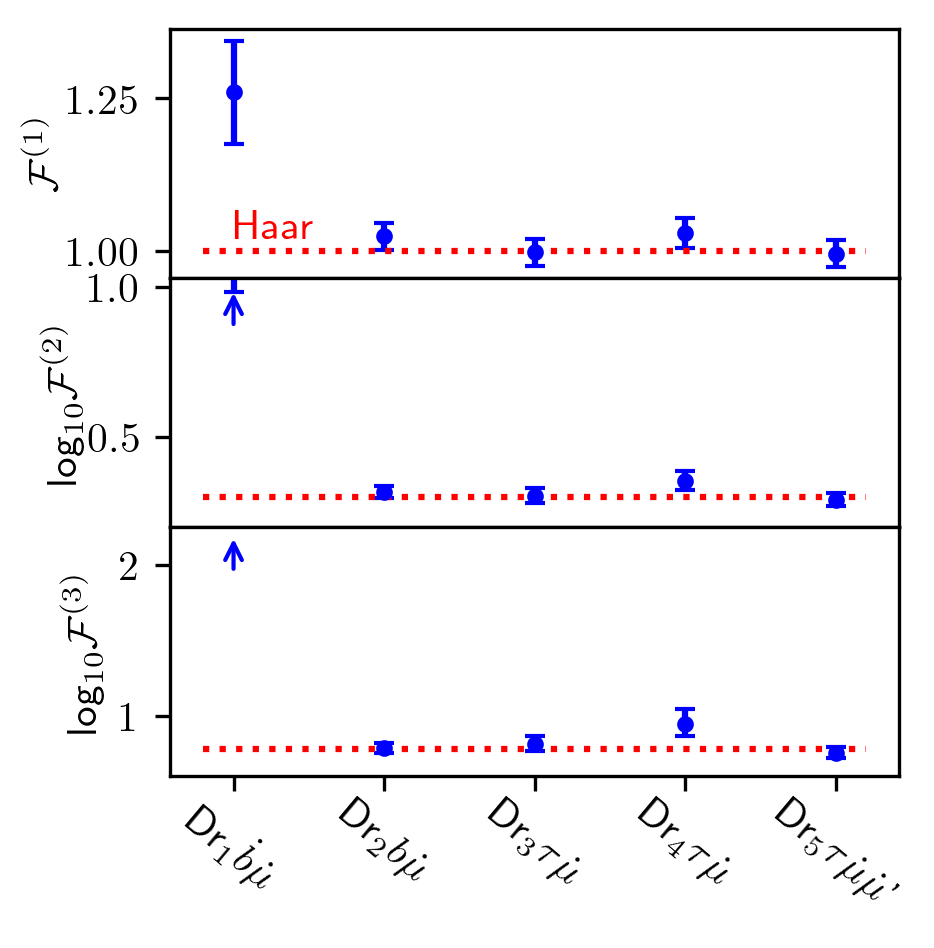

In [375]:
fig,axarr = plt.subplots(3,1,sharex=True,figsize=(3,3),dpi=300)
plt.subplots_adjust(wspace=0,hspace=0,bottom=0.15,top=0.98,left=0.17,right=0.98)
karr = np.arange(nruns_vr)
j=0 
yvals = np.squeeze( mm_large_vr[:,j])
yerrs = np.squeeze( stde_large_vr[:,j])
axarr[j].errorbar(karr,yvals,yerr = yerrs,capsize=2.3,fmt='o',ms=3,color='blue')
for j in range(1,3):
    yvals = np.squeeze( mm_large_vr[:,j])
    ylvals = np.log10(yvals)
    yerrs = np.squeeze( stde_large_vr[:,j])
    yuvals = yvals + yerrs
    ybvals = yvals - yerrs
    ylu = np.log10(yuvals)
    ylb = np.log10(ybvals)
    yerr_up = ylu - ylvals 
    yerr_down = ylvals - ylb
    axarr[j].errorbar(karr,ylvals,yerr = [yerr_up,yerr_down],capsize=2.3,fmt='o',ms=3,color='blue')

axarr[1].set_ylim([0.2,1.03])
axarr[1].annotate("", xytext=(0, 0.85), xy=(0.0, 1.01), arrowprops=dict(arrowstyle="->",ec='blue'))
#axarr[1].annotate("", xytext=(1, 0.85), xy=(1.0, 1.01), arrowprops=dict(arrowstyle="->",ec='blue'))
axarr[2].set_ylim([0.6,2.25])
axarr[2].annotate("", xytext=(0, 1.92), xy=(0.0, 2.23), arrowprops=dict(arrowstyle="->",ec='blue'))
#axarr[2].annotate("", xytext=(1, 1.92), xy=(1.0, 2.23), arrowprops=dict(arrowstyle="->",ec='blue'))
xmin,xmax = axarr[0].get_xlim()
axarr[0].plot([xmin,xmax],[1,1],'r:')
axarr[1].plot([xmin,xmax],[np.log10(2.),np.log10(2.)],'r:')
axarr[2].plot([xmin,xmax],[np.log10(6.),np.log10(6.)],'r:')
axarr[2].tick_params(axis='x', which='major', pad=1)
axarr[2].set_xticks(karr,labels_vr[0:nruns_vr],rotation=-40)   
axarr[0].set_ylabel(r'${\mathcal F}^{(1)}$',labelpad=0.1)
axarr[1].set_ylabel(r'log$_{10}{\mathcal F}^{(2)}$',labelpad=1)
axarr[2].set_ylabel(r'log$_{10}{\mathcal F}^{(3)}$')
axarr[0].annotate('Haar',xytext=(0,1.02),xy=(0,1),color='red',fontsize=10)
plt.savefig(froot+'fp_var.png')
plt.show()

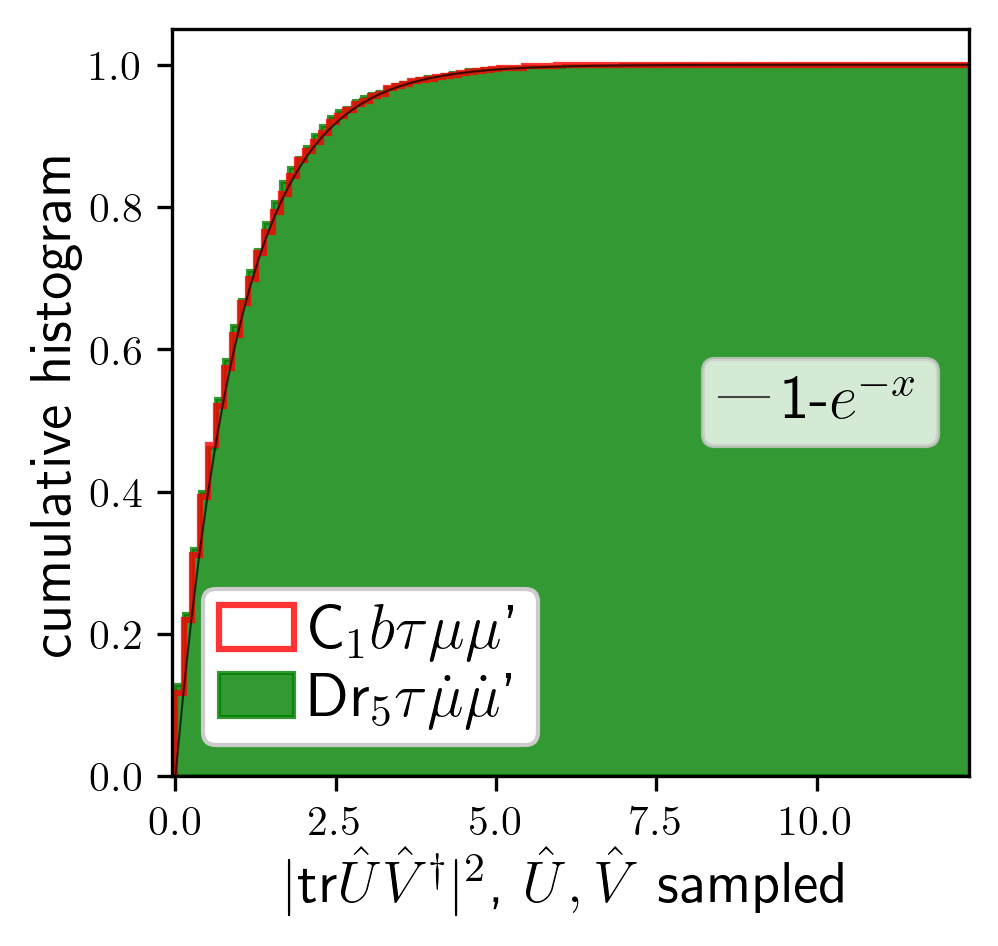

In [416]:
def pltnzhist(zlist_list,labels,xmax,histtypes,ofile):
    #xmax = 10
    fig,ax = plt.subplots(1,1,figsize=(3.2,3.0),dpi=300)
    plt.subplots_adjust(hspace=0,wspace=0,left=0.15,right=0.98,top=0.98,bottom =0.15)
    ax.set_xlim([-0.05,xmax*0.99])

    style1 = {'facecolor': 'red',  'edgecolor': 'red', 'linewidth': 1.5, 'linestyle':'solid'}
    style2 = {'facecolor': 'green', 'edgecolor': 'green', 'linewidth': 1, 'linestyle':'solid'}
    style3 = {'facecolor': 'violet', 'edgecolor': 'violet', 'linewidth': 1.5, 'linestyle':'solid'}
    style4 = {'facecolor': 'cyan',  'edgecolor': 'cyan', 'linewidth': 2.5, 'linestyle':'dotted'}
    stylelist = [ style1, style2, style3, style4 ] 
    for k in range(len(zlist_list)):
        zlist = zlist_list[k]
        bins_arr  = mkbinsarr(0,xmax,100,np.max(zlist))
        style = stylelist[k]
        ax.hist(zlist   ,bins=bins_arr,density=True,alpha=0.8,cumulative=True,histtype=histtypes[k],**style,label = labels[k])
    first_legend = ax.legend(borderpad=0.25,handlelength=1.2,handletextpad=0.25,fontsize=15,labelspacing=0.2,framealpha=1)
    ax.add_artist(first_legend)

    xarr = np.linspace(0,xmax,100)
    yarr = 1 - np.exp(-xarr)
    ylabel = r'1-$e^{-x}$'
    handles = []
    llw, = ax.plot(xarr,yarr,'k-',lw=0.5,alpha=0.7,label=ylabel)
    handles.append(llw)
    second_legend = ax.legend(handles = handles, borderpad=0.25,handlelength=0.8,handletextpad=0.25,fontsize=15,labelspacing=0.05,\
                         loc = 'center right')
    ax.set_ylabel('cumulative histogram',fontsize=14,labelpad=2)
    xlab = r'$|$tr$ \hat U \hat V^\dagger|^2$, ' + r'$\hat U,\hat V$ sampled'
    ax.set_xlabel(xlab,fontsize=14,labelpad=1)
    if (len(ofile)>3):
        plt.savefig(ofile)

    plt.show()

#plt1zhist(zlist)
#print_parr(parr,N)
zlist_list = [zlist_f, zlist_vd]
label_f = r'C$_1b\tau\mu$' + muprime
label_ve = r'Dr$_5$' + r'$\tau$'+dotmu + dotmup
labels = [label_f,label_ve]
ofile = froot + 'cufps.png'
histtypes = ['step', 'stepfilled']
pltnzhist(zlist_list,labels,xmax,histtypes,ofile)
